In [12]:
# ============================
# 1. Imports e configurações
# ============================
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Estilo dos gráficos
sns.set(style="whitegrid", palette="viridis")
plt.rcParams["figure.figsize"] = (10, 6)

# ============================
# 2. Carregar base amostral
# ============================
# Arquivo: base_tratada.csv (separador ";")
df = pd.read_csv("base_tratada.csv", sep=";")

# Conferir as primeiras linhas
df.head()
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191062 entries, 0 to 191061
Data columns (total 15 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   audio_length            191062 non-null  float64
 1   callId                  191062 non-null  float64
 2   callDate                191062 non-null  object 
 3   initiatedAt             191062 non-null  object 
 4   segment                 191062 non-null  object 
 5   terminatedAt            191062 non-null  object 
 6   reason                  191062 non-null  object 
 7   reason_type             191062 non-null  object 
 8   subreasons_description  191062 non-null  object 
 9   position                191062 non-null  float64
 10  sgl_uf                  191062 non-null  object 
 11  customer                191062 non-null  float64
 12  site                    191062 non-null  object 
 13  plan_name               191062 non-null  object 
 14  regiao              

In [13]:
# ============================
# 3. Tratamento inicial
# ============================

# Converter datas/horas
for col in ["callDate", "initiatedAt", "terminatedAt"]:
    df[col] = pd.to_datetime(df[col], errors="coerce")

# Garantir tipo numérico em colunas de medida
df["audio_length"] = pd.to_numeric(df["audio_length"], errors="coerce")
df["position"] = pd.to_numeric(df["position"], errors="coerce")

# Criar duração da chamada a partir de timestamps (fallback para audio_length)
df["call_duration_ts"] = (df["terminatedAt"] - df["initiatedAt"]).dt.total_seconds()
df["call_duration"] = df["call_duration_ts"].fillna(df["audio_length"])

# Criar coluna de dia, hora e dia da semana
df["date"] = df["initiatedAt"].dt.date
df["hour"] = df["initiatedAt"].dt.hour
df["weekday_num"] = df["initiatedAt"].dt.weekday  # 0 = segunda
weekday_map = {
    0: "Seg", 1: "Ter", 2: "Qua", 3: "Qui", 4: "Sex", 5: "Sáb", 6: "Dom"
}
df["weekday"] = df["weekday_num"].map(weekday_map)

# Separar motivos 'speech' (motivo de fala) vs 'script' (fluxo do atendimento)
df_speech = df[df["reason_type"] == "speech"].copy()
df_script = df[df["reason_type"] == "script"].copy()

# ============================
# 4. Tabela em nível de chamada (callId)
# ============================
# Uma chamada pode ter vários segmentos (speech + script).
# Agregar por callId para olhar nível "chamada".

agg_dict = {
    "audio_length": "max",            # duração principal
    "callDate": "min",
    "initiatedAt": "min",
    "terminatedAt": "max",
    "segment": "first",
    "sgl_uf": "first",
    "regiao": "first",
    "customer": "first",
    "site": "first",
    "plan_name": "first",
    "call_duration": "max"
}

calls = df.groupby("callId").agg(agg_dict)
calls["n_segments"] = df.groupby("callId").size()
calls = calls.reset_index()

# Criar features adicionais
calls["date"] = calls["initiatedAt"].dt.date
calls["hour"] = calls["initiatedAt"].dt.hour
calls["weekday_num"] = calls["initiatedAt"].dt.weekday
calls["weekday"] = calls["weekday_num"].map(weekday_map)

calls.head()


,callId,audio_length,callDate,initiatedAt,terminatedAt,segment,sgl_uf,regiao,customer,site,plan_name,call_duration,n_segments,date,hour,weekday_num,weekday
0,1.546938e+09,620.460022,2024-07-15 02:46:14,2024-07-15 02:46:14,2024-07-15 02:56:34.460,pos puro,SP,Sudeste,836.0,Site 1,Plano 1,620.460,17,2024-07-15,2,0,Seg
1,1.546792e+10,291.855011,2024-07-01 06:59:37,2024-07-01 06:59:37,2024-07-01 07:04:28.855,pos puro,MG,Sudeste,729.0,Site 2,Plano 6,291.855,8,2024-07-01,6,0,Seg
2,1.546792e+10,89.543999,2024-07-01 06:57:35,2024-07-01 06:57:35,2024-07-01 06:59:04.544,pos puro,PR,Sul,9959.0,Site 3,Plano 3,89.544,5,2024-07-01,6,0,Seg
3,1.546792e+10,557.213013,2024-07-01 07:16:00,2024-07-01 07:16:00,2024-07-01 07:25:17.213,pos puro,SP,Sudeste,12892.0,Site 3,Plano 3,557.213,6,2024-07-01,7,0,Seg
4,1.546792e+10,1100.333008,2024-07-01 07:26:32,2024-07-01 07:26:32,2024-07-01 07:44:52.333,pos puro,SP,Sudeste,1277.0,Site 4,Plano 25,1100.333,53,2024-07-01,7,0,Seg


## Perfil de cliente e plano

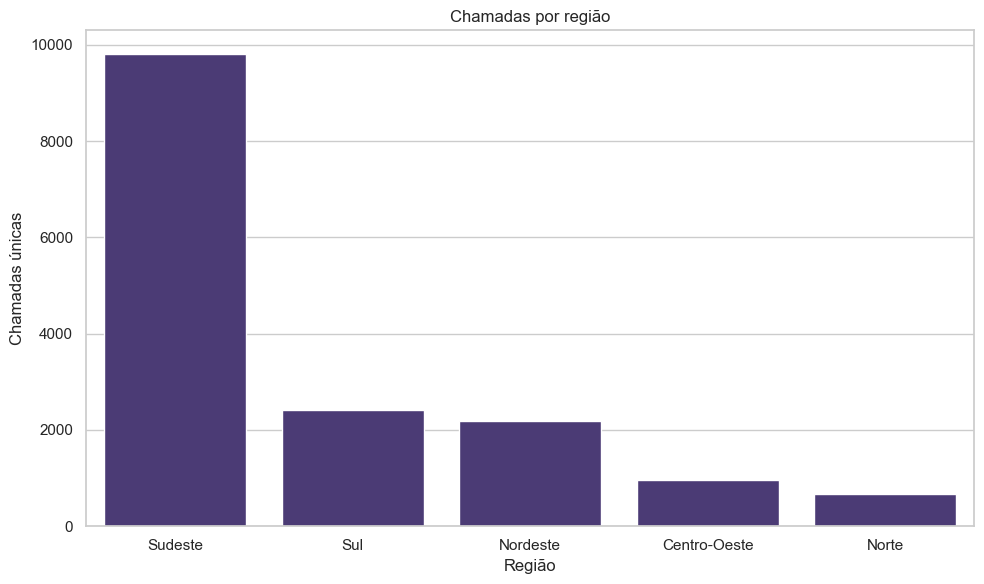

In [18]:
# ============================
# Chamadas por região
# ============================

calls_per_region = (
    calls.groupby("regiao")["callId"]
    .nunique()
    .reset_index(name="n_calls")
    .sort_values("n_calls", ascending=False)
)

fig, ax = plt.subplots()
sns.barplot(data=calls_per_region, x="regiao", y="n_calls", ax=ax)
ax.set_title("Chamadas por região")
ax.set_xlabel("Região")
ax.set_ylabel("Chamadas únicas")
plt.tight_layout()
plt.show()


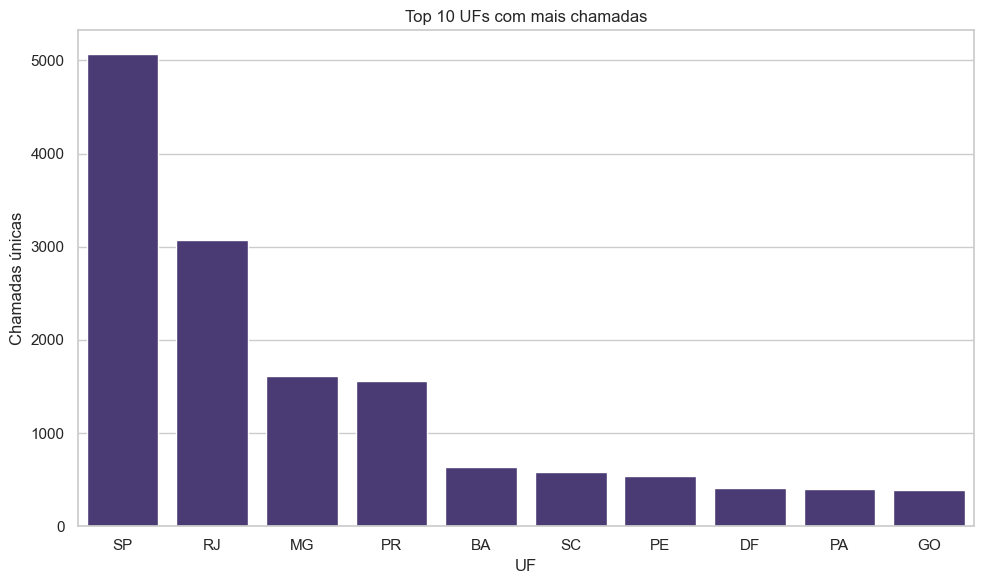

In [19]:
# ============================
# Chamadas por UF (top 10)
# ============================

calls_per_uf = (
    calls.groupby("sgl_uf")["callId"]
    .nunique()
    .reset_index(name="n_calls")
    .sort_values("n_calls", ascending=False)
    .head(10)
)

fig, ax = plt.subplots()
sns.barplot(data=calls_per_uf, x="sgl_uf", y="n_calls", ax=ax)
ax.set_title("Top 10 UFs com mais chamadas")
ax.set_xlabel("UF")
ax.set_ylabel("Chamadas únicas")
plt.tight_layout()
plt.show()

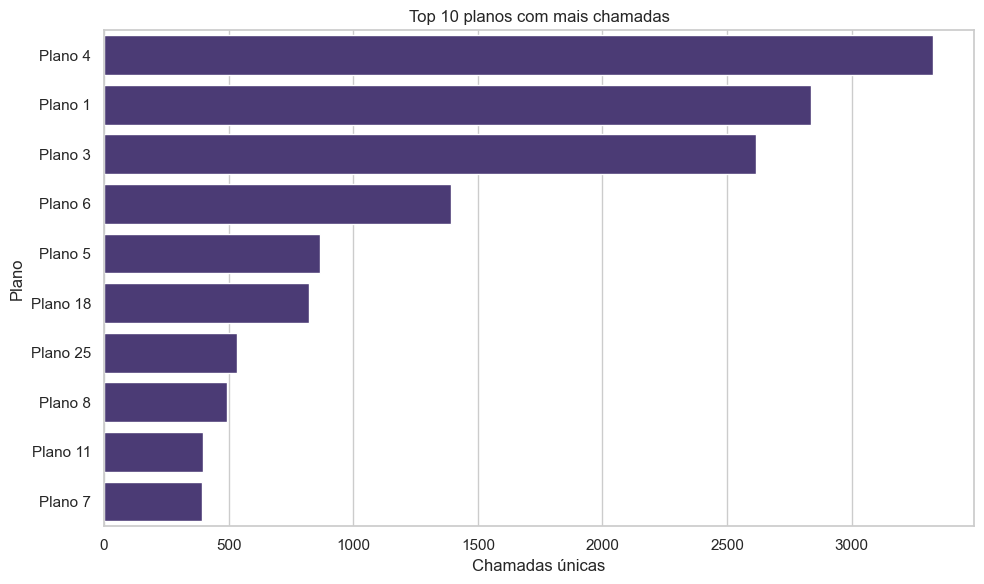

In [20]:
# ============================
# Chamadas por plano (top 10)
# ============================

calls_per_plan = (
    calls.groupby("plan_name")["callId"]
    .nunique()
    .reset_index(name="n_calls")
    .sort_values("n_calls", ascending=False)
    .head(10)
)

fig, ax = plt.subplots()
sns.barplot(data=calls_per_plan, y="plan_name", x="n_calls", ax=ax)
ax.set_title("Top 10 planos com mais chamadas")
ax.set_xlabel("Chamadas únicas")
ax.set_ylabel("Plano")
plt.tight_layout()
plt.show()

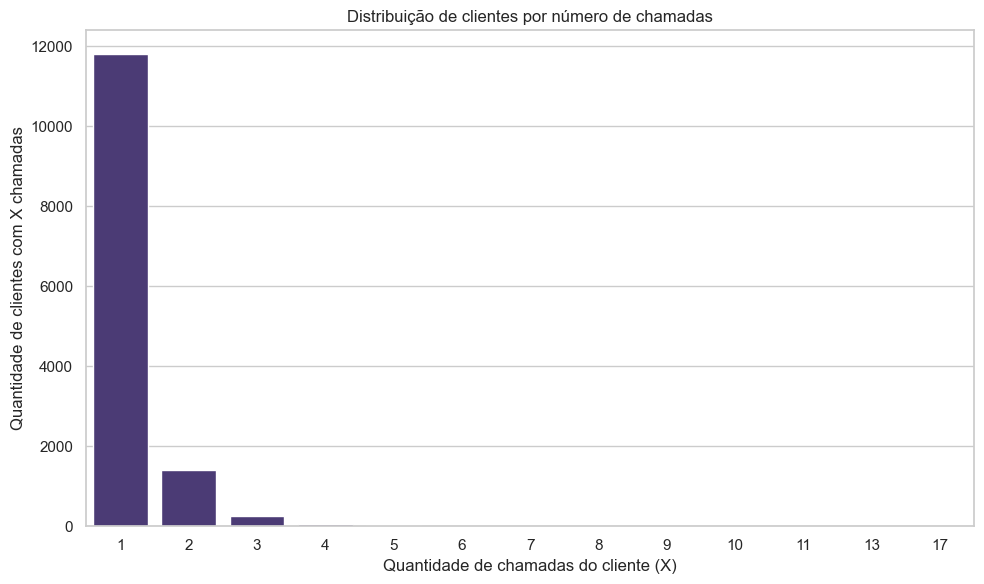

In [48]:
# ============================
# Chamadas por cliente
# ============================

# 1) número de chamadas por cliente
calls_per_customer = (
    calls.groupby("customer")["callId"]
    .nunique()
    .reset_index(name="n_calls")
)

# 2) distribuição: quantos clientes têm X chamadas
dist_calls = (
    calls_per_customer["n_calls"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "n_calls", "count": "n_customers"})
    .sort_values("n_calls")
)

# 3) histograma (na prática é um bar plot discreto)

fig, ax = plt.subplots()
sns.barplot(data=dist_calls, x="n_calls", y="n_customers", ax=ax)
ax.set_title("Distribuição de clientes por número de chamadas")
ax.set_xlabel("Quantidade de chamadas do cliente (X)")
ax.set_ylabel("Quantidade de clientes com X chamadas")
plt.tight_layout()
plt.show()


## Volume de chamadas e tempo

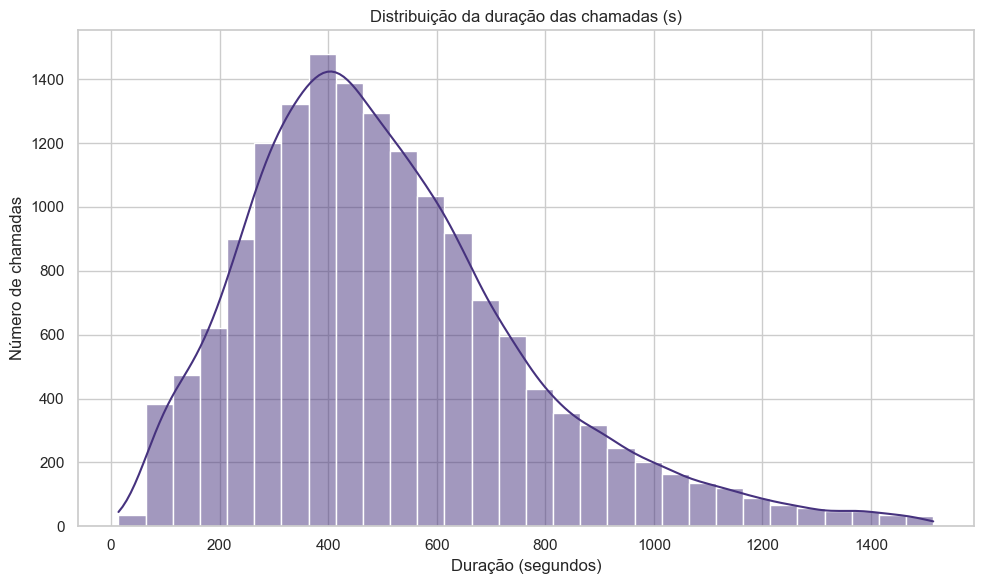

In [14]:
# ============================
# Distribuição da duração das chamadas
# ============================

# Remover outliers extremos para visualização (ex.: acima do percentil 99)
p99 = calls["call_duration"].quantile(0.99)
calls_plot = calls[calls["call_duration"] <= p99]

fig, ax = plt.subplots()
sns.histplot(calls_plot["call_duration"], bins=30, kde=True, ax=ax)
ax.set_title("Distribuição da duração das chamadas (s)")
ax.set_xlabel("Duração (segundos)")
ax.set_ylabel("Número de chamadas")
plt.tight_layout()
plt.show()


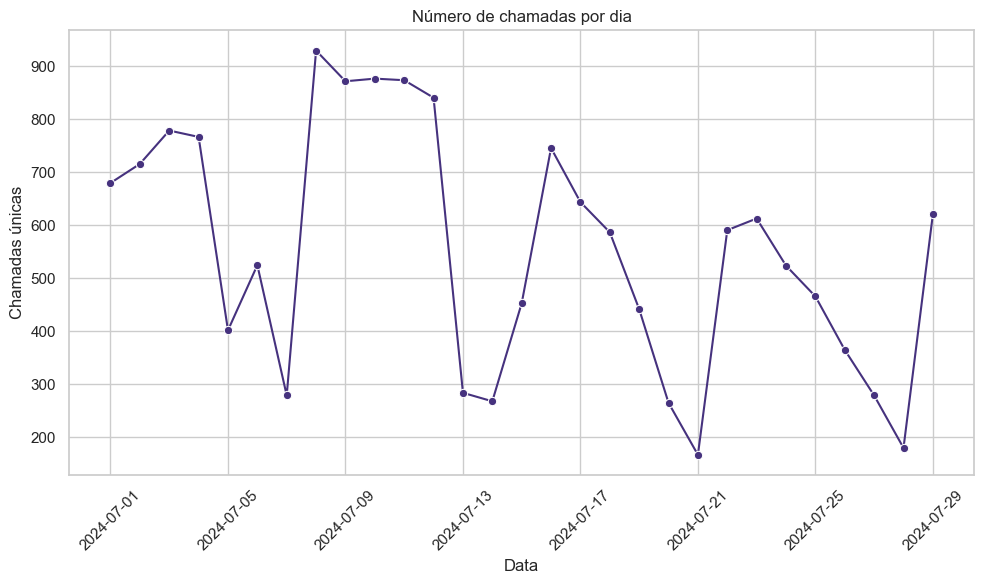

In [15]:
# ============================
# Volume de chamadas por dia
# ============================

calls_per_day = calls.groupby("date")["callId"].nunique().reset_index(name="n_calls")

fig, ax = plt.subplots()
sns.lineplot(data=calls_per_day, x="date", y="n_calls", marker="o", ax=ax)
ax.set_title("Número de chamadas por dia")
ax.set_xlabel("Data")
ax.set_ylabel("Chamadas únicas")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


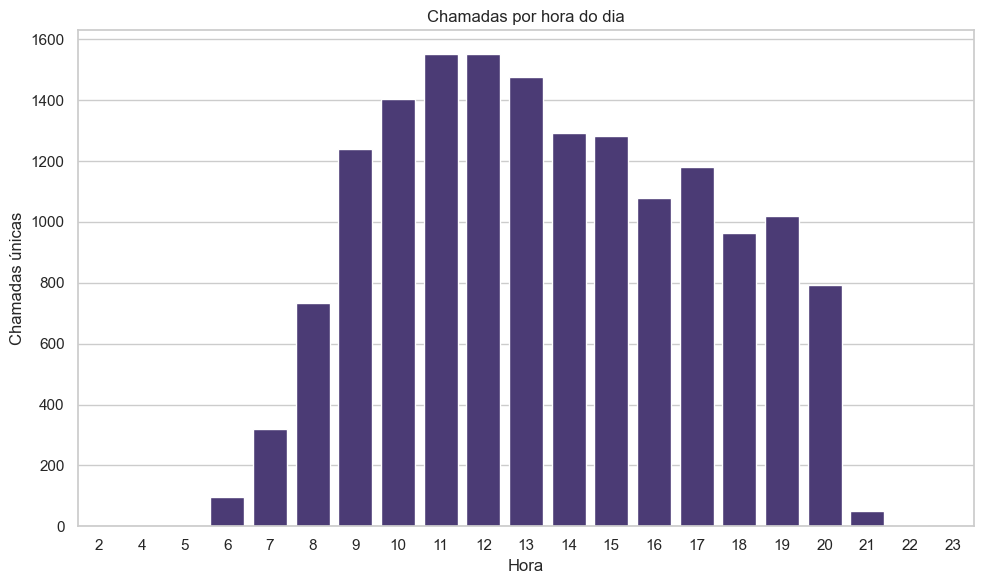

In [16]:
# ============================
# Chamadas por hora do dia
# ============================

calls_per_hour = calls.groupby("hour")["callId"].nunique().reset_index(name="n_calls")

fig, ax = plt.subplots()
sns.barplot(data=calls_per_hour, x="hour", y="n_calls", ax=ax)
ax.set_title("Chamadas por hora do dia")
ax.set_xlabel("Hora")
ax.set_ylabel("Chamadas únicas")
plt.tight_layout()
plt.show()


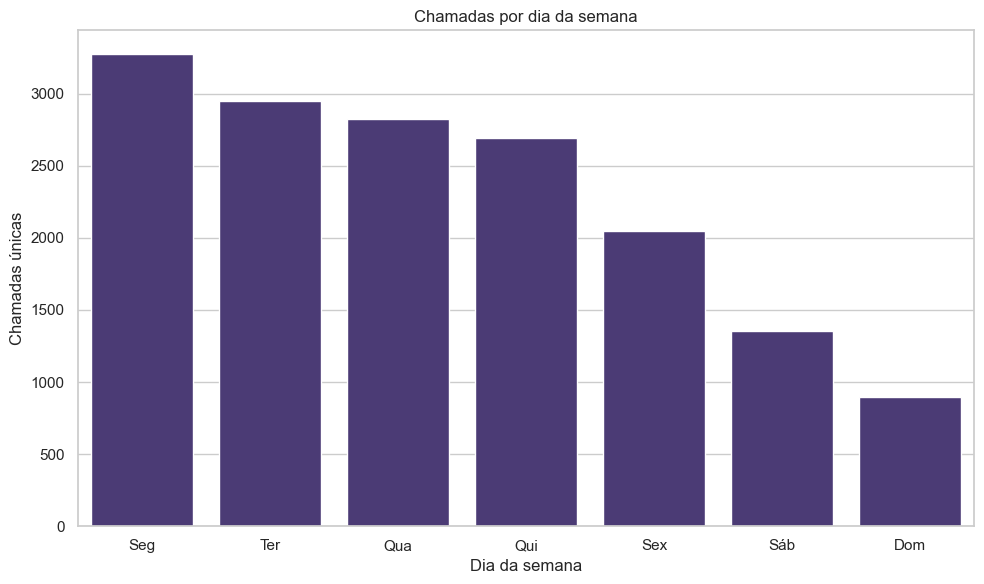

In [17]:
# ============================
# Chamadas por dia da semana
# ============================

calls_per_weekday = (
    calls.groupby(["weekday_num", "weekday"])["callId"]
    .nunique()
    .reset_index(name="n_calls")
    .sort_values("weekday_num")
)

fig, ax = plt.subplots()
sns.barplot(data=calls_per_weekday, x="weekday", y="n_calls", ax=ax)
ax.set_title("Chamadas por dia da semana")
ax.set_xlabel("Dia da semana")
ax.set_ylabel("Chamadas únicas")
plt.tight_layout()
plt.show()


## Principais motivos de ligação

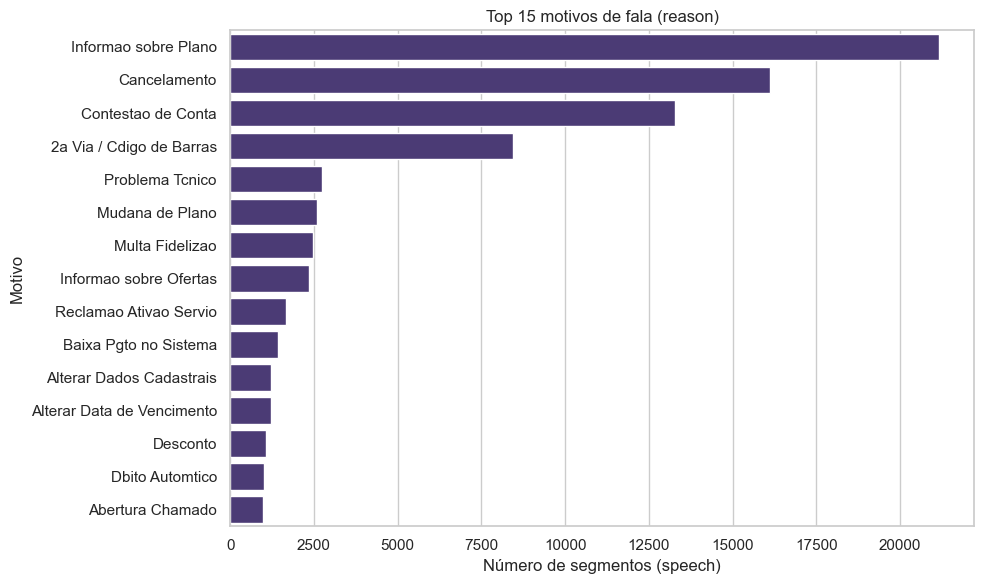

In [33]:
# ============================
# Top motivos (reason) - speech
# ============================

top_reasons = (
    df_speech["reason"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "reason", "count": "n_segments"})
    .head(15)
)

fig, ax = plt.subplots()
sns.barplot(data=top_reasons, y="reason", x="n_segments", ax=ax)
ax.set_title("Top 15 motivos de fala (reason)")
ax.set_xlabel("Número de segmentos (speech)")
ax.set_ylabel("Motivo")
plt.tight_layout()
plt.show()


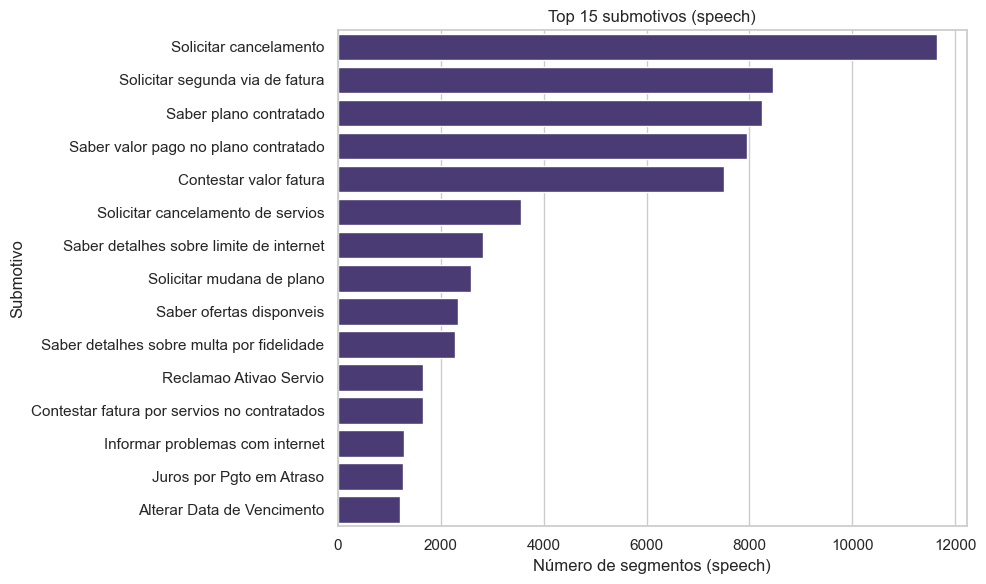

In [34]:
# ============================
# Top submotivos (subreasons_description) - speech
# ============================

top_subreasons = (
    df_speech["subreasons_description"]
    .value_counts()
    .reset_index()
    .rename(columns={"index": "subreasons_description", "count": "n_segments"})
    .head(15)
)

fig, ax = plt.subplots()
sns.barplot(
    data=top_subreasons,
    y="subreasons_description",
    x="n_segments",
    ax=ax
)
ax.set_title("Top 15 submotivos (speech)")
ax.set_xlabel("Número de segmentos (speech)")
ax.set_ylabel("Submotivo")
plt.tight_layout()
plt.show()


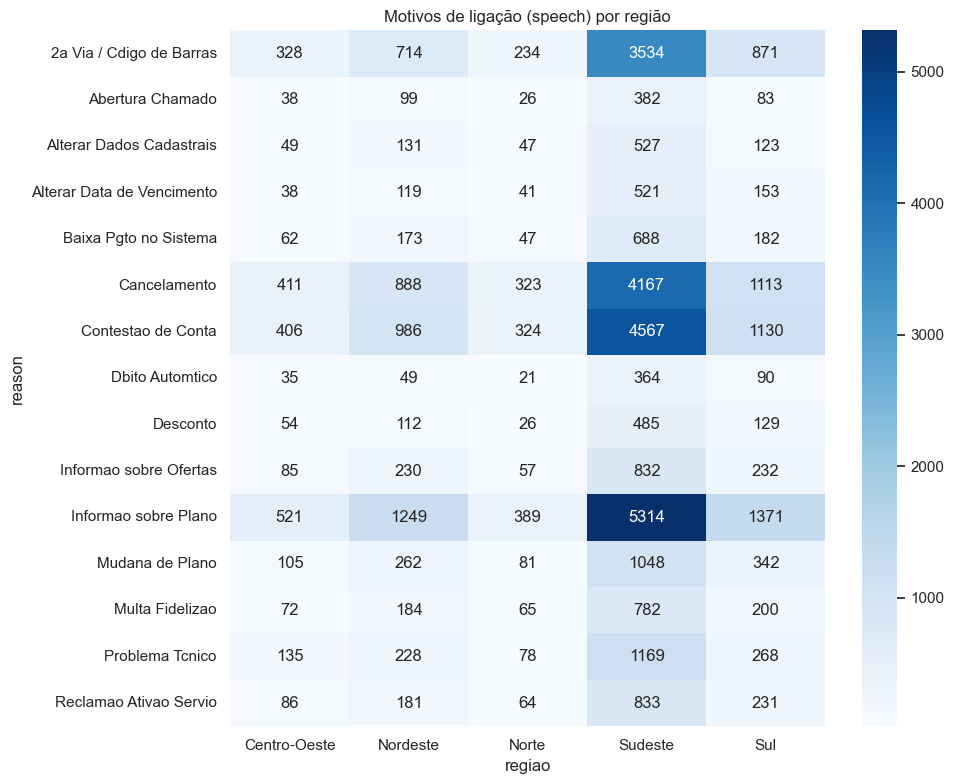

In [35]:
# ============================
# Motivos por região (heatmap)
# ============================

reasons_region = (
    df_speech.groupby(["regiao", "reason"])["callId"]
    .nunique()
    .reset_index(name="n_calls")
)

# Pivot para heatmap (motivos mais frequentes)
top_reason_list = top_reasons["reason"].tolist()
reasons_region_top = reasons_region[reasons_region["reason"].isin(top_reason_list)]

pivot_rr = reasons_region_top.pivot_table(
    index="reason", columns="regiao", values="n_calls", fill_value=0
)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(pivot_rr, annot=True, fmt=".0f", cmap="Blues", ax=ax)
ax.set_title("Motivos de ligação (speech) por região")
plt.tight_layout()
plt.show()


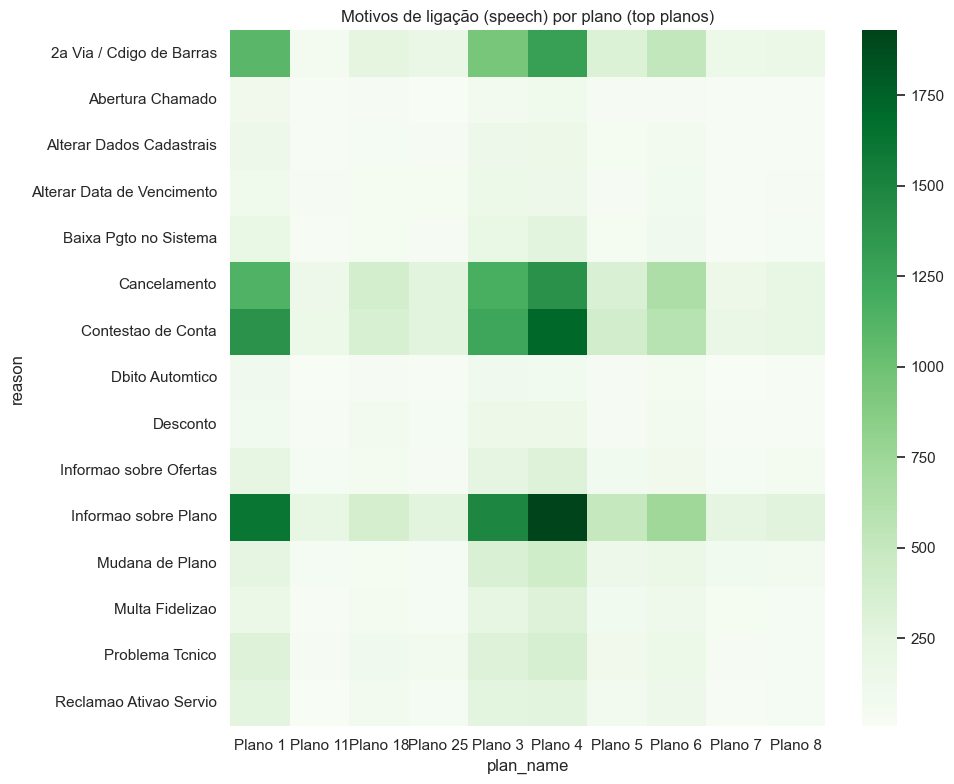

In [36]:
# ============================
# Motivos por plano (heatmap)
# ============================

reasons_plan = (
    df_speech.groupby(["plan_name", "reason"])["callId"]
    .nunique()
    .reset_index(name="n_calls")
)

top_plans = calls_per_plan["plan_name"].tolist()
reasons_plan_top = reasons_plan[
    (reasons_plan["reason"].isin(top_reason_list))
    & (reasons_plan["plan_name"].isin(top_plans))
]

pivot_rp = reasons_plan_top.pivot_table(
    index="reason", columns="plan_name", values="n_calls", fill_value=0
)

fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(pivot_rp, annot=False, cmap="Greens", ax=ax)
ax.set_title("Motivos de ligação (speech) por plano (top planos)")
plt.tight_layout()
plt.show()
